In [4]:
import matplotlib.pyplot as plt
import numpy as np
import joblib
import os
import cv2
from LocalBinaryPattern import LBP as LocBinPat

In [5]:
lbp = LocBinPat()

In [7]:
pca_for_gender = joblib.load("gender_white_pca_model.pkl")
svm_for_gender = joblib.load("gender_white_svm_model.pkl")

pca_for_men_age = joblib.load("men_pca_model.pkl")
svm_for_men_age = joblib.load("men_svm_model.pkl")

pca_for_woomen_age = joblib.load("women_pca_model.pkl")
svm_for_women_age = joblib.load("women_svm_model.pkl")

In [8]:
def classify_all_faces(folder_path='myphotos', file_name='me.jpg'):
    file_path = os.path.join(folder_path, file_name)
    image = cv2.imread(file_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.35, minNeighbors=5, minSize=(10, 10))

    results = []  

    for (x, y, w, h) in faces:
        x, y, w, h = map(int, [x, y, w, h])
        face = image[y:y+h, x:x+w]
        face_resized = cv2.resize(face, (256, 256), interpolation=cv2.INTER_AREA)

        resized_folder = os.path.join(folder_path, 'resized')
        os.makedirs(resized_folder, exist_ok=True)
        image_path = os.path.join(resized_folder, file_name[:-4] + f'_resized_{x}_{y}.jpg')
        cv2.imwrite(image_path, face_resized)

        lbp_image = lbp.get_RGB(image_path)
        histogram = lbp.LBP_histogram(lbp_image)
        x_hist = np.array(histogram).reshape(1, -1)

        x_pca_gender = pca_for_gender.transform(x_hist)
        predicted_gender = svm_for_gender.predict(x_pca_gender)[0]
        gender_label = "Men" if predicted_gender == 0 else "Women"

        if predicted_gender == 0:
            x_pca_age = pca_for_men_age.transform(x_hist)
            probs = svm_for_men_age.predict_proba(x_pca_age)
        else:
            x_pca_age = pca_for_woomen_age.transform(x_hist)
            probs = svm_for_women_age.predict_proba(x_pca_age)

        predicted_class = np.argmax(probs)
        top_3_classes = np.argsort(probs[0])[-3:][::-1]
        top_3_probs = probs[0][top_3_classes]

        age_groups = {
            0: '[0 - 6]',
            1: '[7 - 17]',
            2: '[18 - 28]',
            3: '[29 - 35]',
            4: '[36 - 44]',
            5: '[45 - 53]',
            6: '[54 - 62]',
            7: '[63+]'
        }

        label = f"{gender_label}, Age: {age_groups[predicted_class]}"
        print(f"Face at (x={x}, y={y}):\n{label}")

        results.append({
            'rect': (x, y, w, h),
            'label': label
        })

    for result in results:
        x, y, w, h = result['rect']
        label = result['label']

        rectangle_thickness = 2
        font_scale = 1
        font_thickness = 2

        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), rectangle_thickness)

        text_x = max(int(x - w / 3), 10)
        text_y = int(y + h + 40)
        (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)

        rect_x1 = text_x
        rect_y1 = text_y - text_height - 10
        rect_x2 = text_x + text_width
        rect_y2 = text_y + baseline

        rect_x1 = max(0, rect_x1)
        rect_y1 = max(0, rect_y1)
        rect_x2 = min(image.shape[1], rect_x2)
        rect_y2 = min(image.shape[0], rect_y2)

        overlay = image.copy()
        cv2.rectangle(overlay, (rect_x1, rect_y1), (rect_x2, rect_y2), (255, 255, 255), -1)
        alpha = 0.5
        cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)

        cv2.putText(image, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness)

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

Face at (x=333, y=82):
Men, Age: [54 - 62]
Face at (x=528, y=184):
Women, Age: [54 - 62]


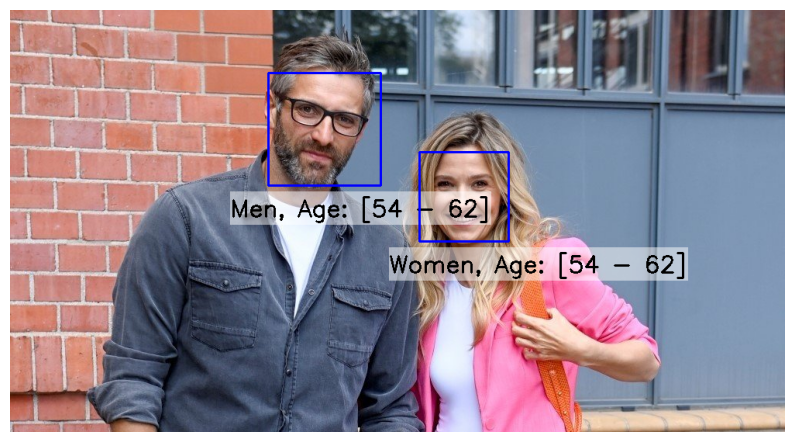

Face at (x=482, y=133):
Men, Age: [54 - 62]


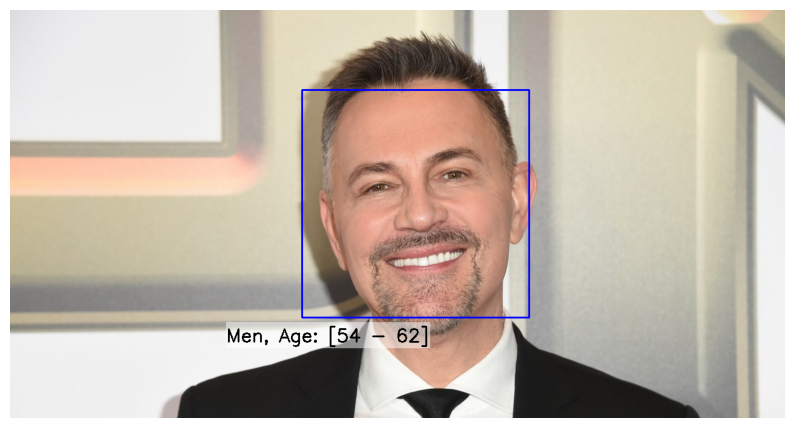

Face at (x=305, y=144):
Men, Age: [36 - 44]


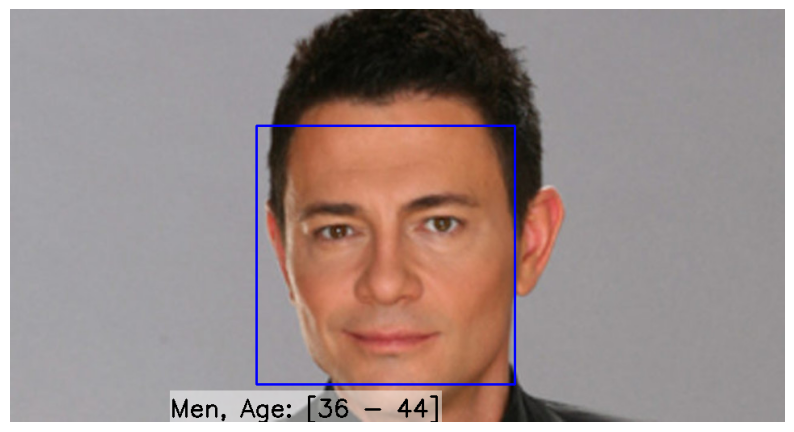

Face at (x=628, y=72):
Men, Age: [54 - 62]


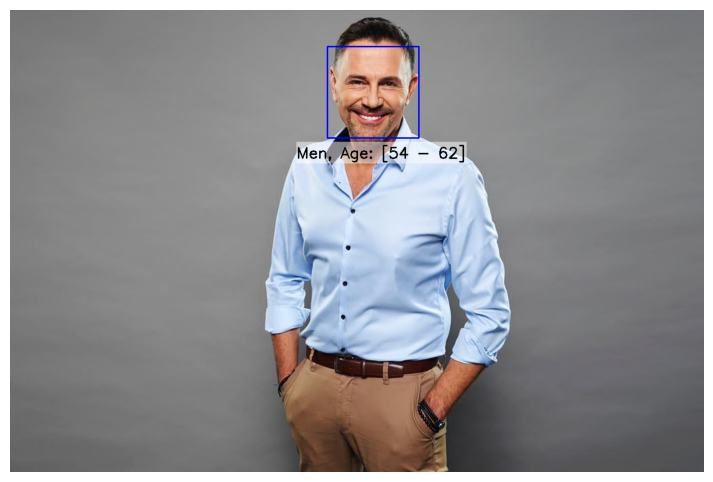

Face at (x=219, y=396):
Men, Age: [7 - 17]


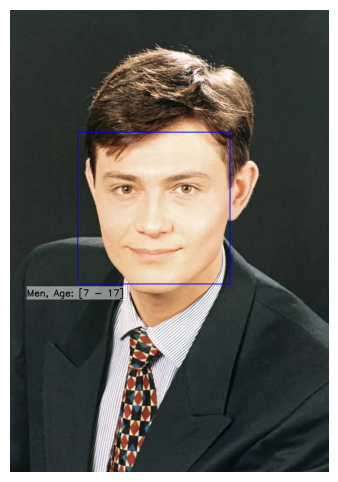

Face at (x=438, y=775):
Men, Age: [7 - 17]


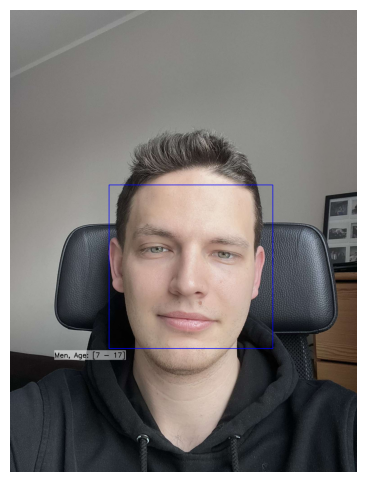

Face at (x=305, y=848):
Men, Age: [54 - 62]


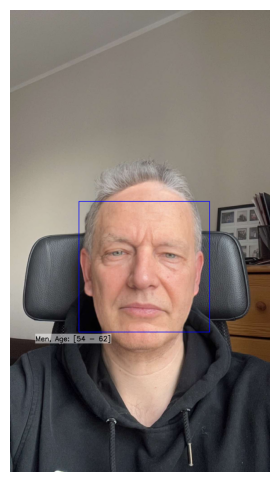

Face at (x=428, y=725):
Men, Age: [63+]


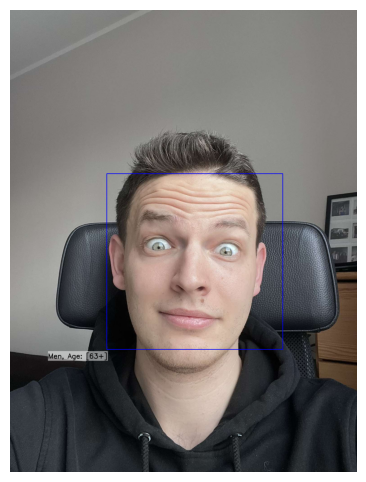

Face at (x=354, y=115):
Women, Age: [18 - 28]


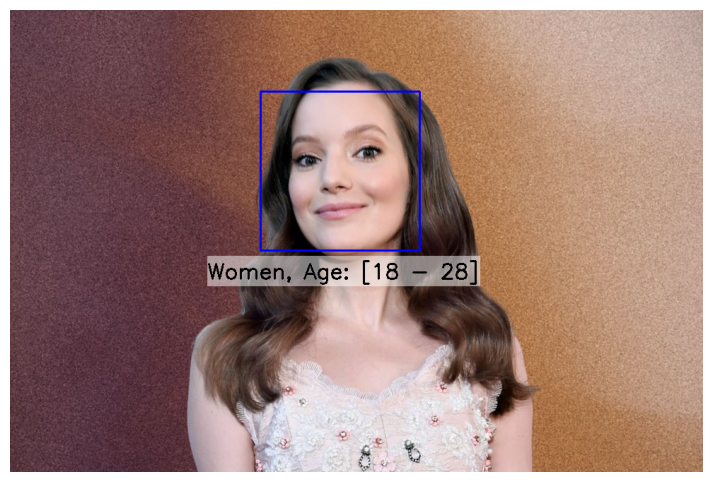

Face at (x=265, y=76):
Men, Age: [18 - 28]
Face at (x=583, y=244):
Women, Age: [18 - 28]


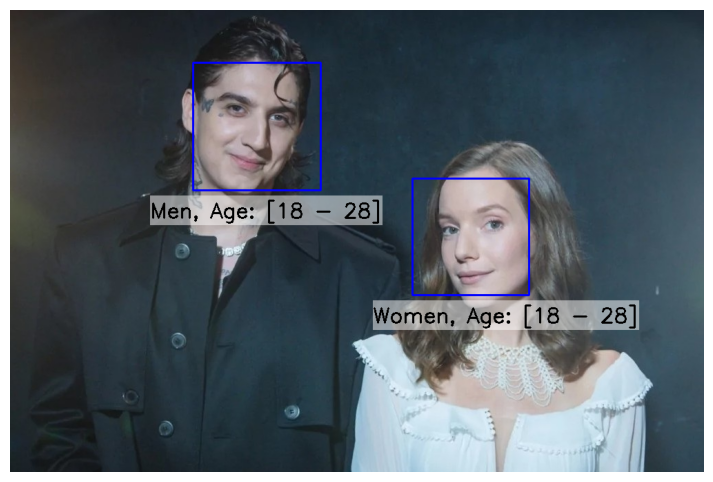

Face at (x=200, y=132):
Men, Age: [29 - 35]


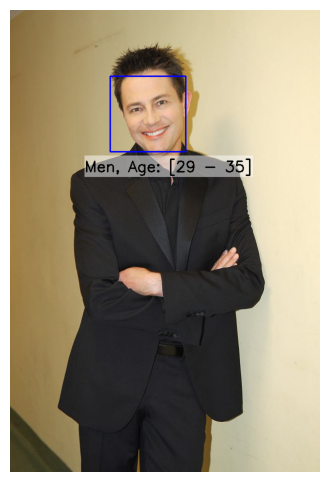

In [9]:
folder_path = "photos"

for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):  
        classify_all_faces(folder_path=folder_path, file_name=filename)
